# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm



import sys
sys.path.append("..") # Adds higher directory to python modules path.


# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *
from DL_utils import *

In [3]:
DATA_PATH = '../data/'
quotation = 'IBM'
FILE_SUFFIX = '.txt'

In [4]:
predict_n = 5

In [5]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=None,
                                           compute_features=True, predict_n=predict_n, normalize=False)

data_wrapper.head()

0          7.393333
1          7.440000
2          7.346667
3          7.353333
4          7.360000
            ...    
14826    124.690002
14827    124.820000
14828    123.800003
14829    124.339996
14830    125.879997
Name: Close, Length: 14831, dtype: float64


,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,7.340000,7.360000,7.320000,7.346667,1.790263,262500,0.020000,54.229741,0.000000,...,7.354667,7.285667,7.331438,0.002343,-0.069000,0.006667,0.000908,higher,7.266667,lower
1,1962-03-22,7.320000,7.320000,7.266667,7.266667,1.770770,240000,0.000000,43.193889,0.026667,...,7.348667,7.292167,7.322802,-0.008636,-0.056500,-0.080000,-0.010889,lower,7.293333,higher
2,1962-03-23,7.273333,7.306667,7.273333,7.293333,1.777267,187500,0.000000,47.061083,0.006666,...,7.340667,7.298833,7.318873,-0.003929,-0.041833,0.026666,0.003670,higher,7.290000,lower
3,1962-03-26,7.293333,7.320000,7.280000,7.290000,1.776455,135000,0.010000,46.633753,0.000000,...,7.333000,7.306667,7.315023,-0.003850,-0.026333,-0.003333,-0.000457,lower,7.153333,lower
4,1962-03-27,7.273333,7.273333,7.146667,7.153333,1.743153,352500,0.006666,33.286703,0.016667,...,7.312333,7.307000,7.293464,-0.021559,-0.005333,-0.136667,-0.018747,lower,7.193333,higher


### Plots

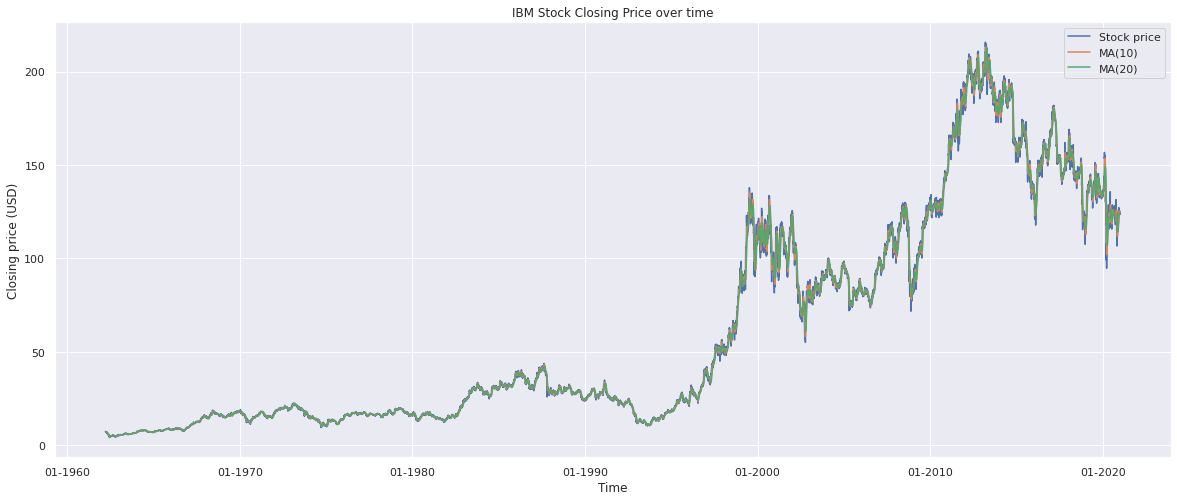

In [6]:
prices = data_wrapper['Close']
plot_prices(price_series=prices, date_series=data_wrapper['Date'], quotation_name=quotation, ma_values=[10,20])
plt.show()

### Plot histogram differences

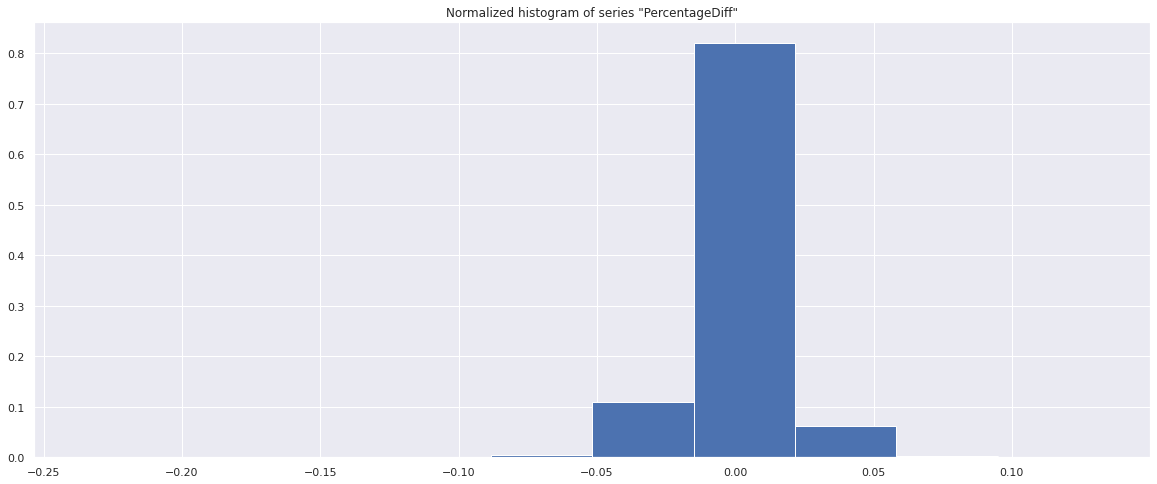

In [7]:
ax = plot_normalized_histogram(data_wrapper['PercentageDiff'])

### ML Data preparation

In [8]:
df = data_wrapper.df

df.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,7.340000,7.360000,7.320000,7.346667,1.790263,262500,0.020000,54.229741,0.000000,...,7.354667,7.285667,7.331438,0.002343,-0.069000,0.006667,0.000908,higher,7.266667,lower
1,1962-03-22,7.320000,7.320000,7.266667,7.266667,1.770770,240000,0.000000,43.193889,0.026667,...,7.348667,7.292167,7.322802,-0.008636,-0.056500,-0.080000,-0.010889,lower,7.293333,higher
2,1962-03-23,7.273333,7.306667,7.273333,7.293333,1.777267,187500,0.000000,47.061083,0.006666,...,7.340667,7.298833,7.318873,-0.003929,-0.041833,0.026666,0.003670,higher,7.290000,lower
3,1962-03-26,7.293333,7.320000,7.280000,7.290000,1.776455,135000,0.010000,46.633753,0.000000,...,7.333000,7.306667,7.315023,-0.003850,-0.026333,-0.003333,-0.000457,lower,7.153333,lower
4,1962-03-27,7.273333,7.273333,7.146667,7.153333,1.743153,352500,0.006666,33.286703,0.016667,...,7.312333,7.307000,7.293464,-0.021559,-0.005333,-0.136667,-0.018747,lower,7.193333,higher


In [9]:
feature_names = data_wrapper.feature_names

print(feature_names)

['LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff', 'Tendency', 'NextPrice', 'Next']


In [10]:
dataset = df.copy()
y_column = 'Next'

feature_names = ['RSI(14)', 'MACD_diff', 'SMA(10)', 'SMA(20)', 
                 'LowLen', 'Close', 'EMA(14)', 'Volume', 'PercentageDiff','MACD']

feature_names = ['RSI(14)', 'MACD', 'Close', 'Volume']
feature_names += [y_column]

dataset = df.loc[:, feature_names]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])
for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':-1})

dataset.head()

,RSI(14),MACD,Close,Volume,Next
0,54.229741,0.015775,7.346667,262500,-1
1,43.193889,0.009074,7.266667,240000,1
2,47.061083,0.005848,7.293333,187500,-1
3,46.633753,0.002988,7.290000,135000,-1
4,33.286703,-0.010190,7.153333,352500,1


### Dataset class balance

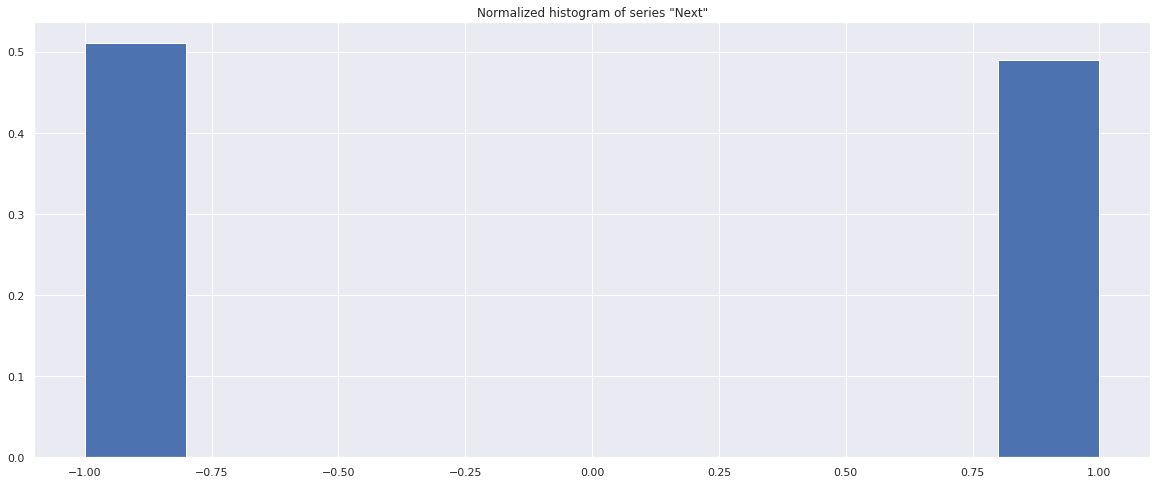

In [11]:
ax = plot_normalized_histogram(dataset.Next)

### Train / Test data 

In [12]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [13]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 10357, test size : 4440 (30%)


## Classifier and evaluation

In [14]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

{-1: 0.9792852415618796, 1: 1.021610052471693}


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[-1  1], y=0       -1
1        1
2       -1
3       -1
4        1
        ..
14792    1
14793    1
14794   -1
14795    1
14796    1
Name: Next, Length: 14797, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4}, 'RandomForest': {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}, 'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}}
param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [17]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.50, F1 : 0.50
[RandomForest] Accuracy : 0.51, F1 : 0.52
[SVM] Accuracy : 0.51, F1 : 0.64
[LR] Accuracy : 0.49, F1 : 0.66


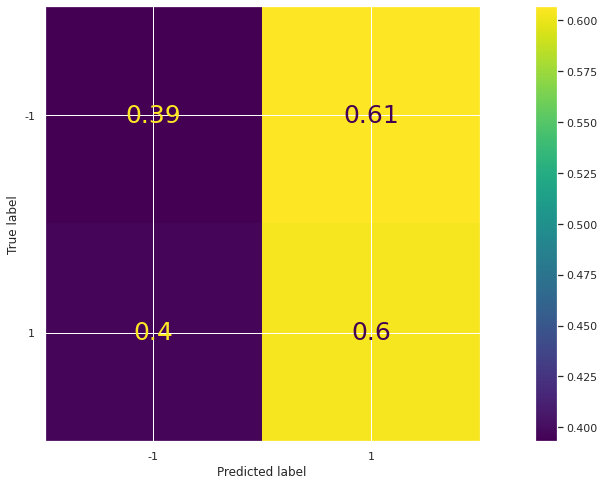

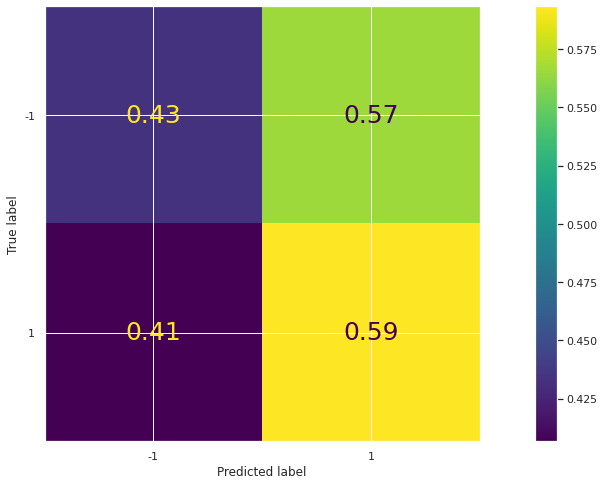

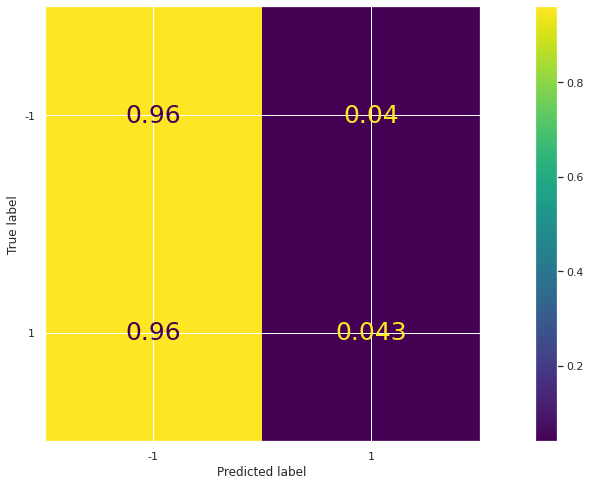

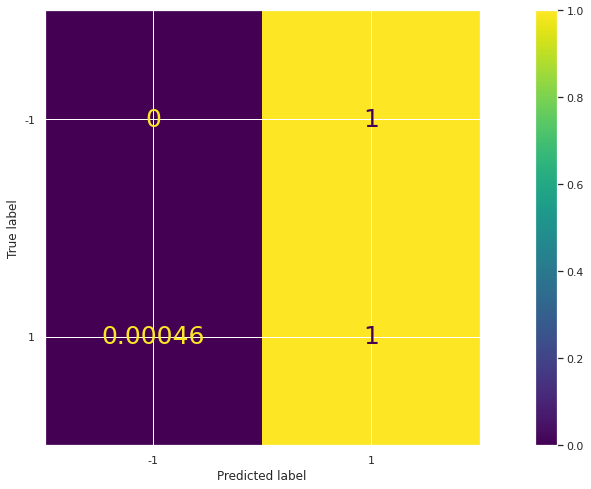

In [18]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_cfm(clf, X_test, Y_test, normalize='true')

|--- Close <= 20.05
|   |--- Close <= 19.91
|   |   |--- RSI(14) <= 72.89
|   |   |   |--- class: -1
|   |   |--- RSI(14) >  72.89
|   |   |   |--- class: -1
|   |--- Close >  19.91
|   |   |--- RSI(14) <= 58.81
|   |   |   |--- class: -1
|   |   |--- RSI(14) >  58.81
|   |   |   |--- class: -1
|--- Close >  20.05
|   |--- Volume <= 15875850.00
|   |   |--- Close <= 210.94
|   |   |   |--- class: 1
|   |   |--- Close >  210.94
|   |   |   |--- class: -1
|   |--- Volume >  15875850.00
|   |   |--- Volume <= 16027000.00
|   |   |   |--- class: 1
|   |   |--- Volume >  16027000.00
|   |   |   |--- class: 1



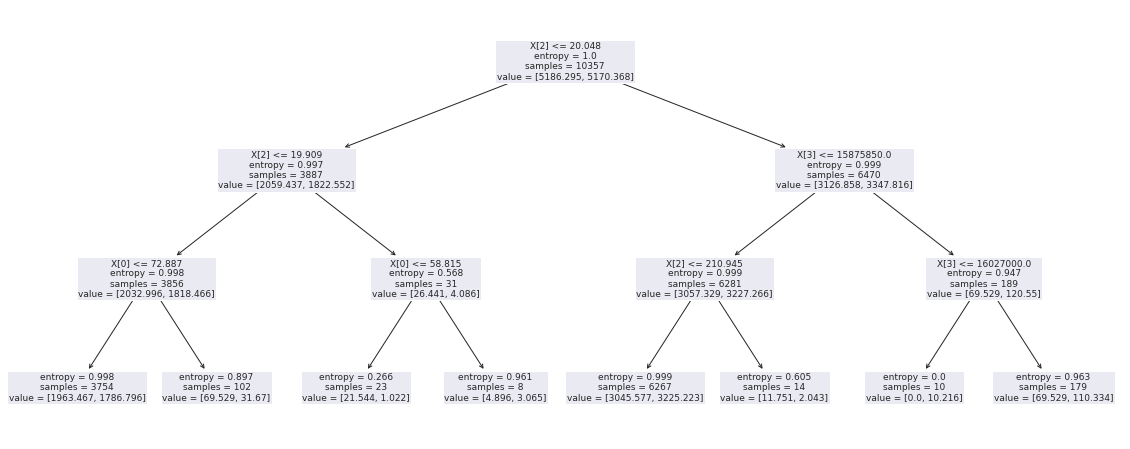

In [21]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [20]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


#feature_names = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, feature_names]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

     RSI(14)      MACD     Close  Volume    Next
0  54.229741  0.015775  7.346667  262500   lower
1  43.193889  0.009074  7.266667  240000  higher
2  47.061083  0.005848  7.293333  187500   lower
3  46.633753  0.002988  7.290000  135000   lower
4  33.286703 -0.010190  7.153333  352500  higher


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)